In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from amorgibbs import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [3]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 10.0

## Model Parameters
num_particles_rws = 10
mcmc_steps = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = int(1000 / mcmc_steps) 
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "stepwise_enc-%drws-%dmcmc-%dsmc-enc-%s" % (num_particles_rws, mcmc_steps, num_particles_smc, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

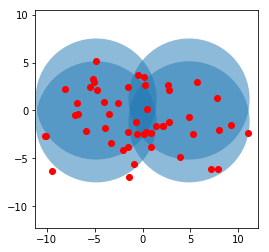

In [4]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle

STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [ ]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [ ]:
EUBOs, ELBOs, KLs, ESSs, enc = stepwise_optimal(enc, D, K, NUM_EPOCHS, num_particles_rws, num_particles_smc, mcmc_steps)

In [ ]:
save_params(KLs, EUBOs, ELBOs, ESSs, PATH_ENC)

In [ ]:
plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [ ]:
# plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)